# EPAT guided mini project 02- solution


#### Date created: 23/08/2022
#### Created by: EPAT Content

The objective of EPAT guided projects is to give you a flavour of solving a real-world problem using Python.  

Here's what we'll do.

- We will give you the step-wise process to follow so that you understand how to analyze a problem and break it down into steps.
- We will give hints for the difficult steps. You can use them if you get stuck somewhere. This will make sure that you do not spend too much time stranded at a particular step. 
- **We urge you to search for solutions on the internet too. That's what you'll do in the outdoors and we think it is an essential part of learning to program.**
- You can explore alternate ways to solve the problem.
- Guided projects are not graded or reviewed. You need to code the solution and run it successfully to evaluate your own progress.
- We provide a model solution of the project against which you can compare your code for self-review.
- The duration of this project is ONE week. You need to complete the project within that time.


Let's begin!

-----

# **Topic: Stock price prediction using LSTM**

**Problem statement:**

Predicting the stock prices in the future is an important use-case in finance. If we can build a model with reasonable accuracy which can help us in predicting the movement of the stock prices for an asset, it can yield good returns.

The Long Short Term Memory ([LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)) networks are a refined version of Recurrent Neural Network (RNN) which perform well on such problems. 

Let us use the LSTM network to predict stock prices for a security.

----

**Steps to perform for this project:**

1. Import the libraries
2. Download the data and check it
3. Data pre-processing
4. Creating the training and test data set
5. Define the features and the labels
6. Define the LSTM model
7. Training the LSTM Model
8. Model Evaluation
9. Visualizing the Predicted Prices

----

## Section 1: Import the libraries

Import the libraries with the aliases given in the brackets below.

_For downloading data_
- `yfinance` (yf)

_For data manipulation_
- `pandas` (pd)
- `numpy` (np)

_For mathematical operations_
- `math`

_For visualization_
- `matplotlib.pyplot` (plt)
- `rcParams` from `matplotlib.pylab`

_For data normalisation_
- `MinMaxScaler` from `sklearn.preprocessing`

_For building the model_
- `LSTM`, `Dropout`, `Dense` from `tensorflow.keras.layers`
- `Sequential` from `tensorflow.keras.models`

_For make the model work only with the CPU_
```python
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
```

In [1]:
# For downloading data
import yfinance as yf

# For manipulating data
import pandas as pd
import numpy as np

# For mathematical operations
import math

# For visualization
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# For data normalisation
from sklearn.preprocessing import MinMaxScaler

# For building the model
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# # Settings the figsize parameter for the plots in this notebook to standardize the size of plots
%matplotlib inline
rcParams['figure.figsize'] = 20, 10

## Section 2: Download the data and check it

Download the last 10-years' historical data for Microsoft (`MSFT`) using `yfinance`.

In [3]:
ticker = 'MSFT'
df = yf.download(ticker, period='10y', auto_adjust= False, group_by="ticker")["MSFT"]

[*********************100%***********************]  1 of 1 completed


In [4]:
# Check the dataset
df.head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-06-17,45.730000,46.070000,45.360001,45.970001,39.860153,28704100
2015-06-18,46.220001,46.799999,46.169998,46.720001,40.510464,32658300
2015-06-19,46.790001,46.830002,45.990002,46.099998,39.972870,63837000
2015-06-22,46.330002,46.720001,46.160000,46.230000,40.085598,20318100
2015-06-23,46.130001,46.279999,45.619999,45.910000,39.808121,25896500


In [5]:
df.tail()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-06-10,471.190002,472.799988,466.959991,470.920013,470.920013,15375900
2025-06-11,470.019989,475.470001,469.660004,472.619995,472.619995,16399200
2025-06-12,475.019989,480.420013,473.519989,478.869995,478.869995,18950600
2025-06-13,476.410004,479.179993,472.760010,474.959991,474.959991,16814500
2025-06-16,475.209991,480.690002,475.000000,479.140015,479.140015,15580000


In [6]:
# Check the number of rows and columns in the dataframe
df.shape

(2515, 6)

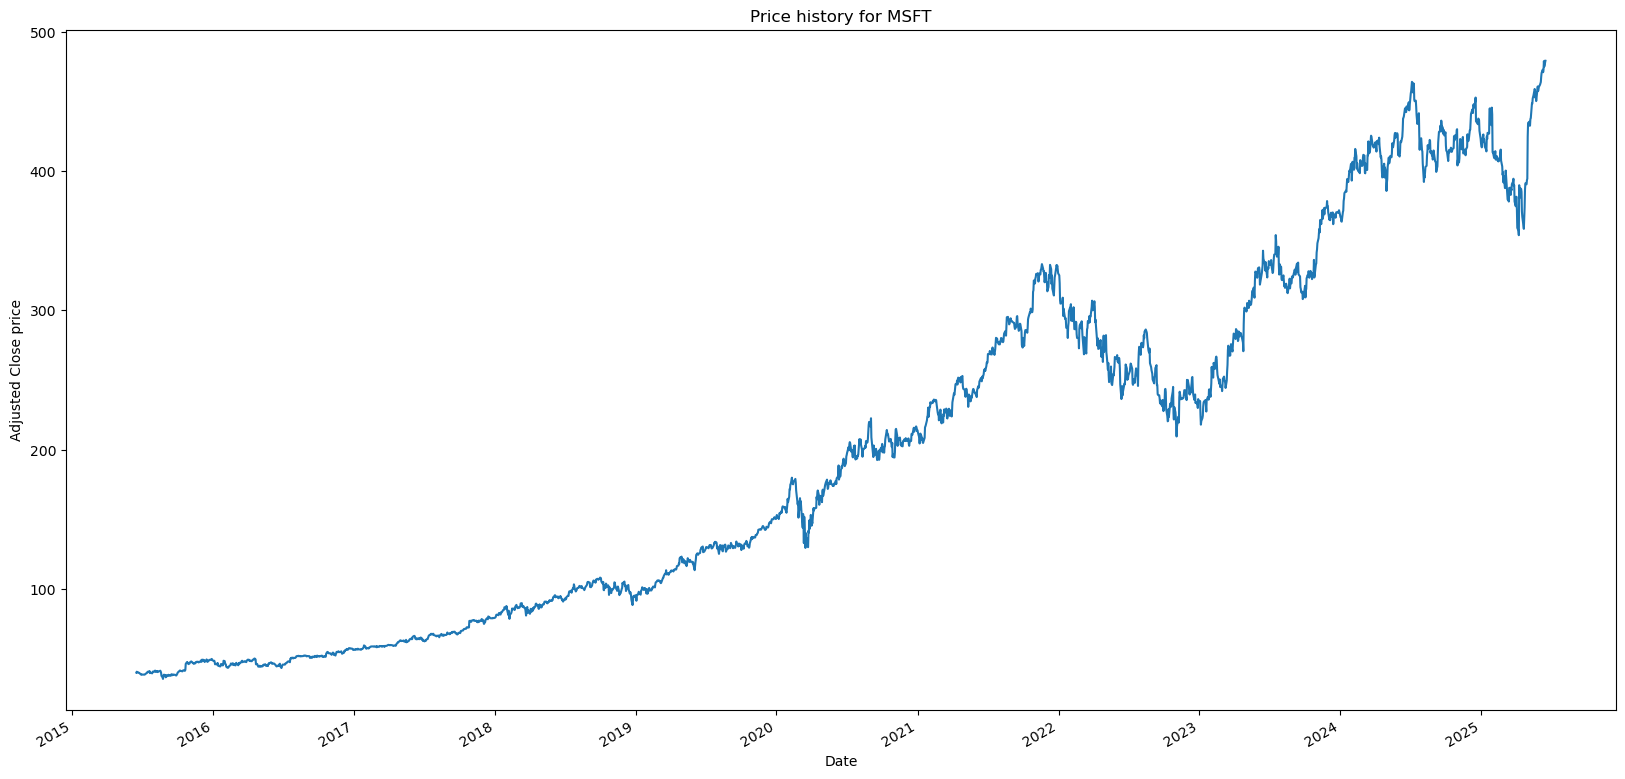

In [7]:
# Plot the adjusted close price
df['Adj Close'].plot()
plt.ylabel('Adjusted Close price')
plt.title(f'Price history for {ticker}')
plt.show()

## Section 3: Data pre-processing

### Filter the dataset

Create a new dataframe with just the adjusted close prices because we will be working only with this data.

In [8]:
# Create a dataframe with just the Adj Close prices
df1 = df[['Adj Close']].copy()

In [9]:
# Check the filtered dataset
df1.head()

Price,Adj Close
Date,
2015-06-17,39.860153
2015-06-18,40.510464
2015-06-19,39.972870
2015-06-22,40.085598
2015-06-23,39.808121


In [10]:
# Check the number of rows and columns in the filtered dataset
df1.shape

(2515, 1)

Rename the column to 'Close' for convenience. It is named as 'Adj Close' currently.

In [11]:
# Rename the column to Close for convenience
df1.rename(columns={'Adj Close':'Close'}, inplace=True)

### Normalize the filtered dataset

Create an array called `prices` with the values of all the close prices from the filtered dataframe.

In [12]:
prices = df1.values

In [13]:
# Check the prices array
prices

array([[ 39.8601532 ],
       [ 40.51046371],
       [ 39.97286987],
       ...,
       [478.86999512],
       [474.95999146],
       [479.14001465]], shape=(2515, 1))

#### Get the data split number

We want 80% of the data for training the model, and 20% for the test data set. So, compute the number of records that are required for the training data set. 

In [14]:
# Computing the number of records we want in the training data set
train_len = math.ceil(len(prices) * 0.8)
train_len

2012

#### Scaling the data

Do the following:
- Reshape the `prices` array with `newshape` as (1, -1)
(Refer to the official documentation to read more about the [numpy.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) method).
<br>**Note**- _The new shape should be compatible with the original shape. If an integer, then the result will be a 1-D array of that length. One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions_
- Fit the scaler to the first `train_len` observations of the `prices`.
- Normalize the data to values between 0 and 1 using `MinMaxScaler`and save it as `scaled_prices`. Remember, that the feature range has to be passed as a tuple.

In [15]:
# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(prices.reshape(-1, 1)[:train_len, :])
scaled_prices = scaler.transform(prices.reshape(-1, 1))

In [16]:
# Check the scaled prices array
scaled_prices

array([[0.01523537],
       [0.01741884],
       [0.01561382],
       ...,
       [1.489249  ],
       [1.47612083],
       [1.49015562]], shape=(2515, 1))

HINT: To normalize the prices array using `MinMaxScaler`, follow the steps below:
- Initialize a MinMaxScaler object with feature_range as (0,1).
- Call the `fit` method of the scaler object and pass the prices' first `train_len` observations.
- Call the `transform` method of the scaler object and pass the entire `prices`.

## Section 4: Creating the training and test data set

Create the training data set with the first 'n' rows of the scaled prices, where 'n' is the number of records required in the training data set, computed above.

In [17]:
# Create the training data set with the first n rows of the scaled prices
# n is the number of records required in the training data set, computed above

train_data = scaled_prices[0:train_len, :]

## Section 5: Define the features and the labels

We should input our data in the form of a 3D array to the LSTM model. First, we create data in 60 timesteps before using numpy to convert it into an array. Finally, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

Do the following steps:

1. Create an empty list for the features `x_train` and labels `y_train`.
2. Create a 60-days window of historical prices as our feature data `x_train` and the following 60-days window as label data `y_train`.

In [18]:
# Create an empty list for the feature data and label data
x_train, y_train = [], []

# Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train).
for i in range(60, len(train_data)):
    x_train.append(scaled_prices[i-60:i, 0])
    y_train.append(scaled_prices[i, 0])

3. Convert the features (x_train) and labels (y_train) into `Numpy` arrays as required by `Tensorflow` when training a neural network model. 

4. Reshape the x_train into a three-dimensional array as `LSTM` supports three-dimensional input.

In [19]:
# Convert the x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape into a three-dimensional array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

5. Extract the closing prices from our normalized dataset (the last 20% of the dataset).

6. Similar to the training set, create feature data (x_test) and label data (y_test) from our test set.

7. Convert the feature data (x_test) and label data (y_test) into Numpy array. Reshape again the x_test and y_test into a three-dimensional array

In [20]:
test_data = scaled_prices[train_len-60:, :]
x_test = []
y_test = prices[train_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Section 6: Define the LSTM model

Now, you are ready to use the open-source machine learning library, Tensorflow, to set up our LSTM network architecture.

Write code for the following:
1. Define a Sequential model which consists of a linear stack of layers.
2. Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length.
3. Add another LSTM layer with also 100 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence.
4. Add a densely connected neural network layer with 25 network units.
5. At last, add a densely connected layer that specifies the output of 1 network unit.
6. Show the summary of this LSTM network architecture.

In [21]:
#  Define a Sequential model which consists of a linear stack of layers.
model = Sequential()

# Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another LSTM layer with also 100 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence
model.add(LSTM(100, return_sequences=False))

# Add a densely connected neural network layer with 25 network units
model.add(Dense(25))

# Add a densely connected layer that specifies the output of 1 network unit
model.add(Dense(1))

# Show the summary of our LSTM network architecture
model.summary()

/home/josgt/anaconda3/envs/quantinsti_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

## Section 7: Training the LSTM Model

You are almost ready to train your LSTM model by fitting it with the training set. But before that, you have to set an optimizer and a loss function for the model.

Do the following:
- Adopt `adam` optimizer and set the mean square error as loss function. You need to use the `compile()` method for this. Pass 'adam' to the `optimizer` parameter, and 'mean_squared_error' to the `loss` parameter.

- Train the model by fitting it with the training set. We can try with batch_size of 1 and run the training for 3 epochs. Use the model `fit()` method for it.

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0038
Epoch 2/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 8.0455e-04
Epoch 3/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 6.4204e-04


## Section 8: Model Evaluation

Now, you need to evaluate your trained LSTM model with the test set. Examine the performance of the model using the root mean square error (RMSE) metric.

Here are the steps:
1. Apply the model to predict the stock prices based on the test set using the `predict()` method.
2. Use the `inverse_transform()` method to denormalize the predicted stock prices.
3. Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result

In [23]:
# Apply the model to predict the stock prices based on the test set
predictions = model.predict(x_test)
# Use the inverse_transform method to denormalize the predicted stock prices
predictions = scaler.inverse_transform(predictions)
# Apply the RMSE formula to evaluate the correctness of the predictions
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


np.float64(11.091193282235423)

## Section 9: Visualizing the Predicted Prices

It is always helpful to visualize the predicted prices in a graphical way. Plot the predicted stock price and the real stock price using Matplolib.

/tmp/ipykernel_157737/3478114823.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Predictions'] = predictions


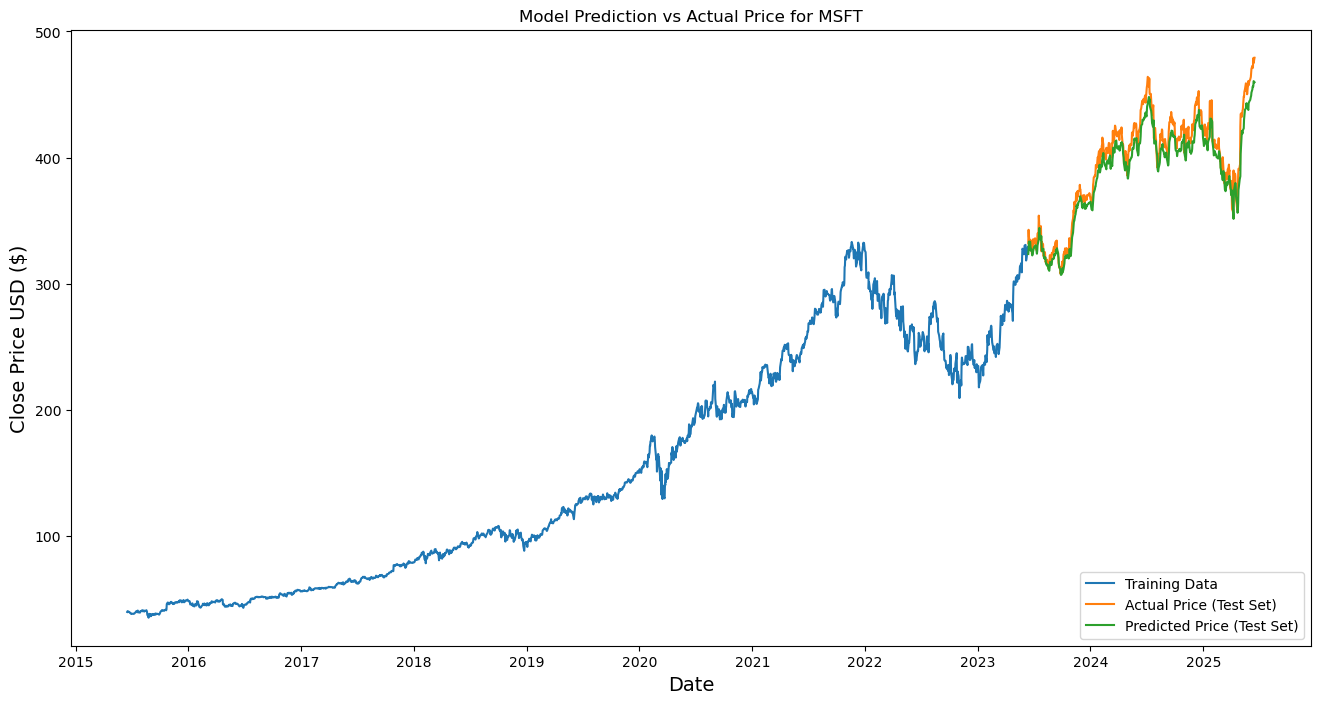

In [24]:
# Section 9: Visualizing the Predicted Prices

# Create a new dataframe for plotting
# The 'train' part will hold the data the model was trained on
# The 'validation' part will hold the actual prices and the model's predictions for the test set
data = df.filter(['Adj Close'])
train_data = data[:train_len]
validation_data = data[train_len:]
validation_data['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title(f'Model Prediction vs Actual Price for {ticker}')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Plot the training and validation data
plt.plot(train_data['Adj Close'])
plt.plot(validation_data['Adj Close'])
plt.plot(validation_data['Predictions'])

# Add a clear legend
plt.legend(['Training Data', 'Actual Price (Test Set)', 'Predicted Price (Test Set)'], loc='lower right')

plt.show()

You can observe that LSTM has predicted stocks almost similar to actual stocks. But a closer inspection would be needed.